Implentasi Kalman Filter

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Inisialisasi parameter
dt = 0.1  # Waktu sampling
A = np.array([[1, dt], [0, 1]])  # Matriks transisi keadaan
B = np.array([[0.5 * dt ** 2], [dt]])  # Matriks input kontrol
H = np.array([[1, 0]])  # Matriks pengamatan
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Noise proses
R = np.array([[0.01]])  # Noise pengukuran
x = np.array([[0], [1]])  # Keadaan awal: posisi=0, kecepatan=1
P = np.eye(2)  # Kovariansi awal


In [14]:
# Data simulasi
true_position = []
measurements = []
predictions = []

# Simulasi gerak dan pengukuran
np.random.seed(42)
for t in np.arange(0, 10, dt):
    # Posisi sebenarnya
    true_pos = x[0, 0] + np.random.normal(0, 0.1)
    true_position.append(true_pos)

    # Pengukuran dengan noise
    z = true_pos + np.random.normal(0, np.sqrt(R[0, 0]))
    measurements.append(z)

    # Prediksi (Proses Kalman Filter)
    x = A @ x  # Prediksi keadaan
    P = A @ P @ A.T + Q  # Prediksi kovariansi

    # Update
    K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)  # Kalman Gain
    x = x + K @ (z - H @ x)  # Koreksi
    P = (np.eye(2) - K @ H) @ P  # Update kovariansi

    # Simpan hasil prediksi
    predictions.append(x[0, 0])

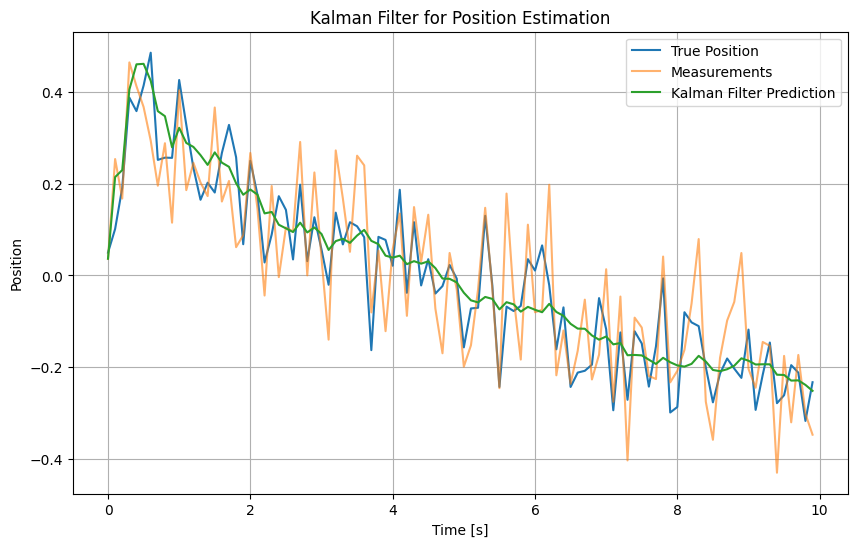

In [15]:
# Plot hasil
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 10, dt), true_position, label="True Position")
plt.plot(np.arange(0, 10, dt), measurements, label="Measurements", alpha=0.6)
plt.plot(np.arange(0, 10, dt), predictions, label="Kalman Filter Prediction")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.title("Kalman Filter for Position Estimation")
plt.grid()
plt.show()

Implementasi Partikel Filter

In [16]:
# Parameter simulasi
num_particles = 1000  # Jumlah partikel
dt = 0.1  # Waktu sampling
true_velocity = 1.0  # Kecepatan sebenarnya
sensor_noise = 0.5  # Noise pengukuran
motion_noise = 0.1  # Noise gerakan
sim_time = 10.0  # Durasi simulasi

In [17]:
# Inisialisasi partikel
particles = np.random.uniform(0, 10, num_particles)  # Posisi awal acak
weights = np.ones(num_particles) / num_particles  # Bobot awal

# Data untuk plotting
true_positions = []
measurements = []
estimates = []

# Fungsi resampling
def resample(particles, weights):
    indices = np.random.choice(len(particles), size=len(particles), p=weights)
    return particles[indices]

In [18]:
# Simulasi
np.random.seed(42)
for t in np.arange(0, sim_time, dt):
    # Posisi sebenarnya
    true_pos = t * true_velocity
    true_positions.append(true_pos)

    # Pengukuran dengan noise
    measurement = true_pos + np.random.normal(0, sensor_noise)
    measurements.append(measurement)

    # Perbarui partikel berdasarkan model gerakan
    particles += true_velocity * dt + np.random.normal(0, motion_noise, num_particles)

    # Hitung bobot berdasarkan pengukuran
    weights = np.exp(-0.5 * ((particles - measurement) / sensor_noise) ** 2)
    weights += 1e-300  # Untuk menghindari pembagian dengan nol
    weights /= np.sum(weights)

    # Estimasi posisi (rata-rata berbobot)
    estimate = np.sum(particles * weights)
    estimates.append(estimate)

    # Resampling
    particles = resample(particles, weights)

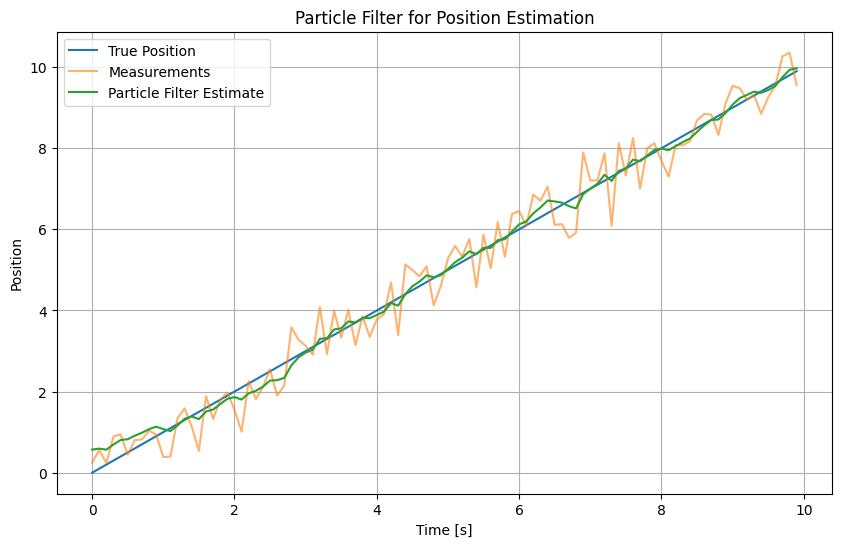

In [19]:
# Plot hasil
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, sim_time, dt), true_positions, label="True Position")
plt.plot(np.arange(0, sim_time, dt), measurements, label="Measurements", alpha=0.6)
plt.plot(np.arange(0, sim_time, dt), estimates, label="Particle Filter Estimate")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.title("Particle Filter for Position Estimation")
plt.grid()
plt.show()

Implementasi Localization 

In [20]:
# Parameter simulasi
dt = 0.1  # Waktu sampling
sim_time = 10.0  # Durasi simulasi
true_velocity = 1.0  # Kecepatan sebenarnya
imu_bias = 0.2  # Bias pada sensor IMU
imu_noise = 0.3  # Noise pada IMU
lidar_noise = 0.5  # Noise pada Lidar


In [21]:
# Data simulasi
true_positions = []
imu_readings = []
lidar_readings = []
estimates = []

# Variabel estimasi
position_estimate = 0.0
velocity_estimate = 0.0

# Noise covariance
R_imu = imu_noise**2  # Kovariansi noise IMU
R_lidar = lidar_noise**2  # Kovariansi noise Lidar
P = np.eye(2)  # Kovariansi awal (posisi dan kecepatan)

# Matriks sistem (untuk Kalman Filter)
A = np.array([[1, dt], [0, 1]])  # Model transisi
H_imu = np.array([[0, 1]])  # Pengukuran kecepatan dari IMU
H_lidar = np.array([[1, 0]])  # Pengukuran posisi dari Lidar
Q = np.array([[1e-4, 0], [0, 1e-4]])  # Noise proses


In [22]:
# Simulasi
np.random.seed(42)
for t in np.arange(0, sim_time, dt):
    # Posisi sebenarnya
    true_position = t * true_velocity
    true_positions.append(true_position)

    # Pengukuran IMU (kecepatan dengan bias dan noise)
    imu_measurement = true_velocity + imu_bias + np.random.normal(0, imu_noise)
    imu_readings.append(imu_measurement)

    # Pengukuran Lidar (posisi dengan noise)
    lidar_measurement = true_position + np.random.normal(0, lidar_noise)
    lidar_readings.append(lidar_measurement)

    # Prediksi (Kalman Filter)
    x = np.array([[position_estimate], [velocity_estimate]])
    x = A @ x  # Prediksi keadaan
    P = A @ P @ A.T + Q  # Prediksi kovariansi

    # Update dengan IMU (kecepatan)
    K_imu = P @ H_imu.T @ np.linalg.inv(H_imu @ P @ H_imu.T + R_imu)
    x = x + K_imu @ (imu_measurement - H_imu @ x)
    P = (np.eye(2) - K_imu @ H_imu) @ P

    # Update dengan Lidar (posisi)
    K_lidar = P @ H_lidar.T @ np.linalg.inv(H_lidar @ P @ H_lidar.T + R_lidar)
    x = x + K_lidar @ (lidar_measurement - H_lidar @ x)
    P = (np.eye(2) - K_lidar @ H_lidar) @ P

    # Simpan estimasi
    position_estimate, velocity_estimate = x.flatten()
    estimates.append(position_estimate)

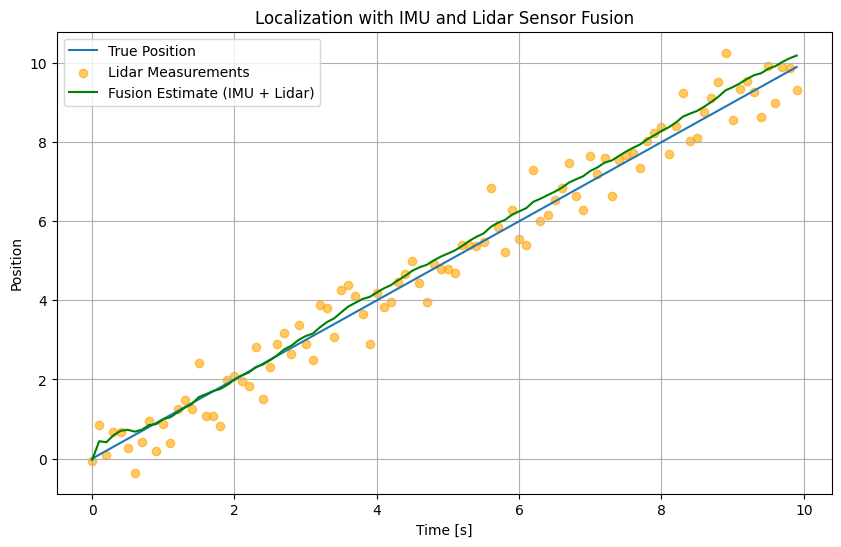

In [23]:
# Plot hasil
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, sim_time, dt), true_positions, label="True Position")
plt.scatter(np.arange(0, sim_time, dt), lidar_readings, label="Lidar Measurements", color="orange", alpha=0.6)
plt.plot(np.arange(0, sim_time, dt), estimates, label="Fusion Estimate (IMU + Lidar)", color="green")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.title("Localization with IMU and Lidar Sensor Fusion")
plt.grid()
plt.show()

Implementasi Simulasi Ekstensi Kalman Filter

In [24]:
# Parameter simulasi
dt = 0.1  # Waktu sampling
sim_time = 10.0  # Durasi simulasi
radius = 10.0  # Radius lingkaran
omega = 0.5  # Kecepatan sudut (rad/s)
process_noise = np.diag([0.1, 0.1, 0.01])  # Noise proses (x, y, theta)
measurement_noise = np.diag([0.5, 0.5])  # Noise pengukuran (x, y)


In [25]:
# Fungsi model gerak (nonlinear)
def motion_model(state, u):
    x, y, theta = state
    v, w = u
    x_next = x + v * np.cos(theta) * dt
    y_next = y + v * np.sin(theta) * dt
    theta_next = theta + w * dt
    return np.array([x_next, y_next, theta_next])

# Fungsi Jacobian untuk model gerak
def jacobian_motion(state, u):
    _, _, theta = state
    v, _ = u
    F = np.array([
        [1, 0, -v * np.sin(theta) * dt],
        [0, 1,  v * np.cos(theta) * dt],
        [0, 0, 1]
    ])
    return F

# Fungsi Jacobian untuk pengukuran
def jacobian_measurement(state):
    return np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

# Fungsi pengukuran (x, y)
def measurement_model(state):
    return state[:2]

# Inisialisasi
state = np.array([radius, 0, np.pi / 2])  # (x, y, theta)
covariance = np.eye(3)  # Kovariansi awal
true_states = []
measurements = []
estimates = []

In [26]:
# Simulasi
np.random.seed(42)
for t in np.arange(0, sim_time, dt):
    # Gerakan sebenarnya
    true_state = motion_model(state, [omega * radius, omega])
    true_states.append(true_state)

    # Pengukuran dengan noise
    measurement = measurement_model(true_state) + np.random.multivariate_normal([0, 0], measurement_noise)
    measurements.append(measurement)

    # Prediksi (EKF)
    predicted_state = motion_model(state, [omega * radius, omega])
    F = jacobian_motion(state, [omega * radius, omega])
    covariance = F @ covariance @ F.T + process_noise

    # Update (EKF)
    H = jacobian_measurement(predicted_state)
    K = covariance @ H.T @ np.linalg.inv(H @ covariance @ H.T + measurement_noise)
    state = predicted_state + K @ (measurement - measurement_model(predicted_state))
    covariance = (np.eye(3) - K @ H) @ covariance

    # Simpan hasil estimasi
    estimates.append(state)

# Konversi ke array
true_states = np.array(true_states)
measurements = np.array(measurements)
estimates = np.array(estimates)


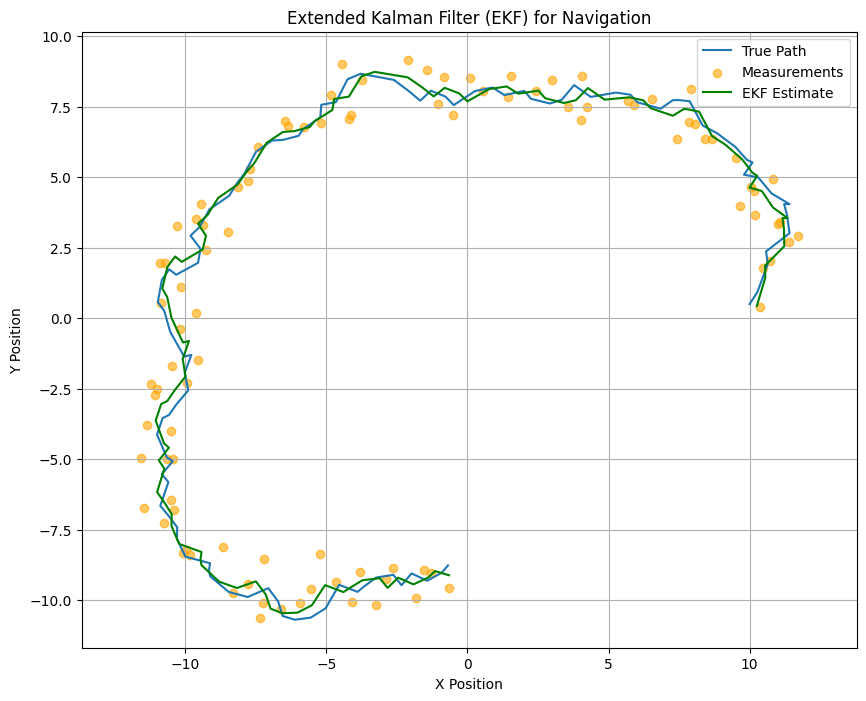

In [27]:
# Plot hasil
plt.figure(figsize=(10, 8))
plt.plot(true_states[:, 0], true_states[:, 1], label="True Path")
plt.scatter(measurements[:, 0], measurements[:, 1], label="Measurements", color="orange", alpha=0.6)
plt.plot(estimates[:, 0], estimates[:, 1], label="EKF Estimate", color="green")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Extended Kalman Filter (EKF) for Navigation")
plt.axis("equal")
plt.grid()
plt.show()

Implementasi Partikel Filter untuk navigasi

In [28]:
# Parameter simulasi
num_particles = 500  # Jumlah partikel
dt = 0.1  # Waktu sampling
sim_time = 10.0  # Durasi simulasi
radius = 10.0  # Radius lingkaran
omega = 0.5  # Kecepatan sudut (rad/s)
motion_noise = np.array([0.2, 0.2, 0.05])  # Noise gerak (x, y, theta)
measurement_noise = np.array([0.5, 0.5])  # Noise pengukuran (x, y)


In [29]:
# Fungsi model gerak
def motion_model(state, u):
    x, y, theta = state
    v, w = u
    x_next = x + v * np.cos(theta) * dt
    y_next = y + v * np.sin(theta) * dt
    theta_next = theta + w * dt
    return np.array([x_next, y_next, theta_next])

# Fungsi pengukuran
def measurement_model(state):
    return state[:2]

# Resampling
def resample(particles, weights):
    indices = np.random.choice(len(particles), size=len(particles), p=weights)
    return particles[indices]

# Inisialisasi partikel
particles = np.random.uniform(-10, 10, (num_particles, 3))  # (x, y, theta)
weights = np.ones(num_particles) / num_particles

# Data simulasi
true_states = []
measurements = []
estimates = []


In [30]:
# Simulasi
np.random.seed(42)
true_state = np.array([radius, 0, np.pi / 2])  # (x, y, theta)
for t in np.arange(0, sim_time, dt):
    # Gerakan sebenarnya
    true_state = motion_model(true_state, [omega * radius, omega])
    true_states.append(true_state)

    # Pengukuran dengan noise
    measurement = measurement_model(true_state) + np.random.normal(0, measurement_noise)
    measurements.append(measurement)

    # Update partikel berdasarkan model gerak
    for i in range(num_particles):
        particles[i] = motion_model(particles[i], [omega * radius, omega])
        particles[i] += np.random.normal(0, motion_noise, 3)

    # Hitung bobot berdasarkan pengukuran
    for i in range(num_particles):
        diff = measurement - measurement_model(particles[i])
        weights[i] = np.exp(-0.5 * np.sum((diff / measurement_noise) ** 2))

    # Normalisasi bobot
    weights += 1e-300  # Untuk mencegah pembagian dengan nol
    weights /= np.sum(weights)

    # Resampling
    particles = resample(particles, weights)

    # Estimasi posisi (rata-rata berbobot)
    estimate = np.average(particles, axis=0, weights=weights)
    estimates.append(estimate)

# Konversi ke array
true_states = np.array(true_states)
measurements = np.array(measurements)
estimates = np.array(estimates)


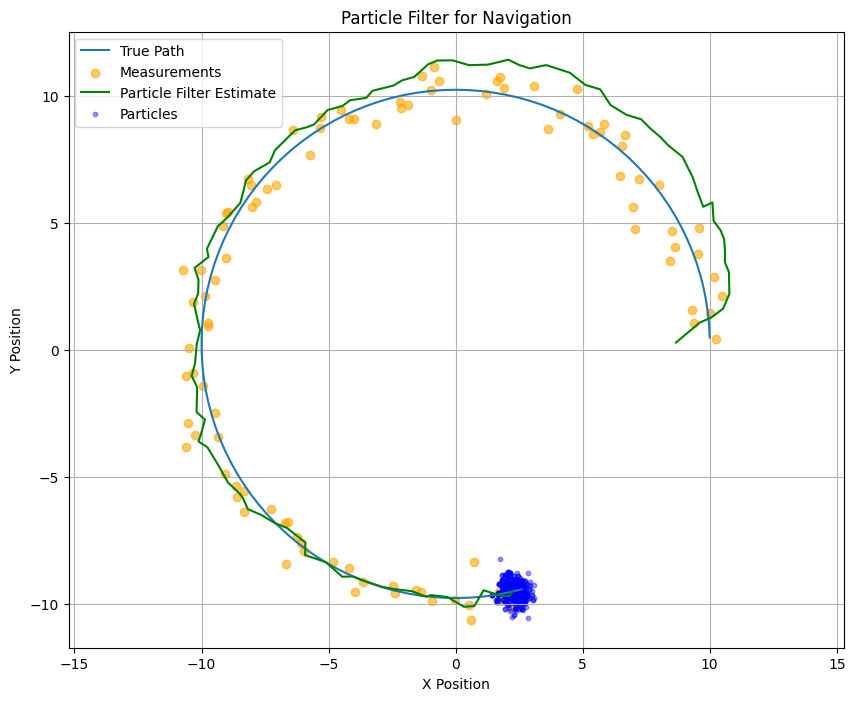

In [31]:
# Plot hasil
plt.figure(figsize=(10, 8))
plt.plot(true_states[:, 0], true_states[:, 1], label="True Path")
plt.scatter(measurements[:, 0], measurements[:, 1], label="Measurements", color="orange", alpha=0.6)
plt.plot(estimates[:, 0], estimates[:, 1], label="Particle Filter Estimate", color="green")
plt.scatter(particles[:, 0], particles[:, 1], label="Particles", color="blue", alpha=0.4, s=10)
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Particle Filter for Navigation")
plt.axis("equal")
plt.grid()
plt.show()
